In [114]:
import os
import tensorflow as tf
import glob
import pathlib
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Model

In [115]:
train="../test_sample/train"
test="../test_sample/test"
valid="../test_sample/valid"

In [116]:
def process(data):
    path=pathlib.Path(data)#converting the dtring to path
    filepaths=list(path.glob(r"*/*.jpg"))#Going through all the subpaths
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))#Separating the label from filepath and storing it
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1)#Making the dataframe
    return df

In [117]:
df_train=process(train)
df_test=process(test)
df_valid=process(valid)

In [118]:
df_train=df_train.sample(frac=1).reset_index(drop=True)#Shuffling the dataframe so we can get random bird pictures

In [119]:
duck_df = pd.DataFrame()
for i in range(len(df_train)):
    if ("DUCK" in df_train["filepaths"][i]):
        duck_df = duck_df.append(df_train.loc[i])
        df_train = df_train.drop(i)
print(duck_df)

                                          filepaths           labels
32           ../test_sample/train/TEAL DUCK/100.jpg        TEAL DUCK
36     ../test_sample/train/RED HEADED DUCK/015.jpg  RED HEADED DUCK
92        ../test_sample/train/MANDRIN DUCK/042.jpg     MANDRIN DUCK
166          ../test_sample/train/WOOD DUCK/060.jpg        WOOD DUCK
302       ../test_sample/train/STEAMER DUCK/099.jpg     STEAMER DUCK
...                                             ...              ...
54500   ../test_sample/train/HARLEQUIN DUCK/052.jpg   HARLEQUIN DUCK
54515  ../test_sample/train/RED HEADED DUCK/054.jpg  RED HEADED DUCK
54531     ../test_sample/train/STEAMER DUCK/071.jpg     STEAMER DUCK
54553     ../test_sample/train/STEAMER DUCK/100.jpg     STEAMER DUCK
54593     ../test_sample/train/STEAMER DUCK/033.jpg     STEAMER DUCK

[1029 rows x 2 columns]


In [120]:
len(df_train)

53623

In [121]:
df_train=df_train.sample(n = 2000)

In [122]:
df_train = df_train
len(df_train)


2000

In [123]:
df_train = pd.concat([duck_df, df_train]).reset_index(drop=True)

In [127]:
labels = df_train.labels.unique()
for i in range(len(df_valid)):
    if (df_valid["labels"][i] not in labels):
        df_valid = df_valid.drop(i)

KeyError: 715

In [102]:
print(len(df_train.labels.unique()))
len(df_valid.labels.unique())

372


371

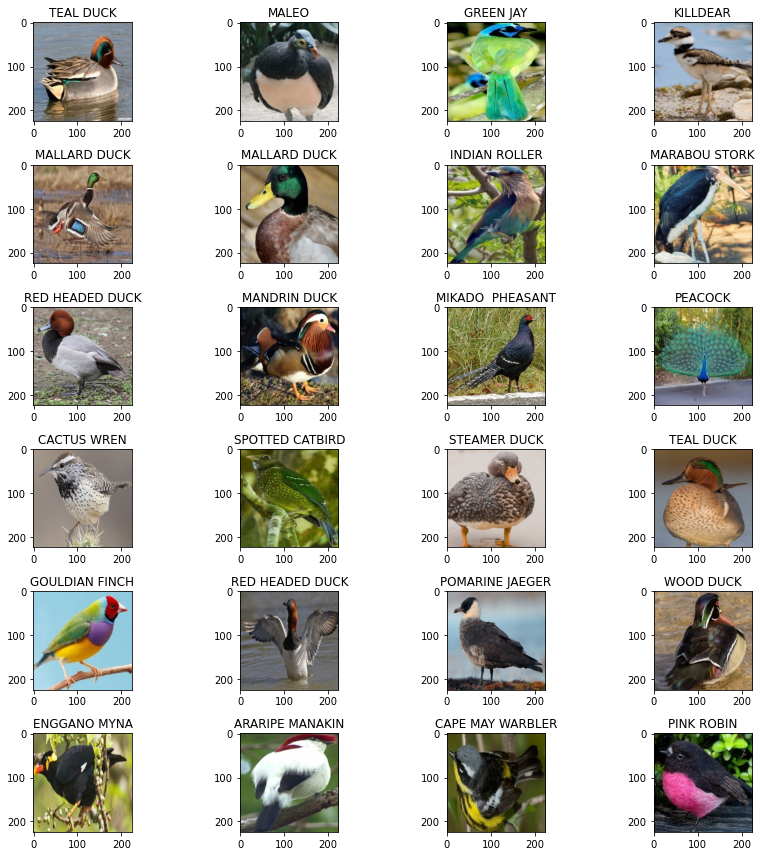

In [103]:
df_train=df_train.sample(frac=1).reset_index(drop=True)#Shuffling the dataframe so we can get random bird pictures
fig,axes=plt.subplots(nrows=6,ncols=4,figsize=(12,12))

for i,ax in enumerate(axes.flat):
    x=plt.imread(df_train['filepaths'][i])#reading the image
    ax.imshow(x)
    ax.set_title(df_train['labels'][i])
plt.tight_layout()    
plt.show()   

In [104]:
train_generator=ImageDataGenerator( preprocessing_function=preprocess_input)
test_generator=ImageDataGenerator( preprocessing_function=preprocess_input)
valid_generator=ImageDataGenerator( preprocessing_function=preprocess_input)

In [105]:
train_image=train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=(224,224),
                                                batch_size=16,
                                                subset='training',
                                                random_seed=42)

test_image = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    batch_size=32
)

valid_image = test_generator.flow_from_dataframe(
    dataframe=df_valid,
    x_col='filepaths',
    y_col='labels',
    subset='training',
    target_size=(224,224),
    batch_size=2
)

Found 3029 validated image filenames belonging to 372 classes.
Found 1875 validated image filenames belonging to 375 classes.
Found 1855 validated image filenames belonging to 371 classes.


In [106]:
pretrained_model = ResNet50(
    input_shape=(224,224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False#We don't want to train again th resnet

In [107]:
inputs = pretrained_model.input

x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)#adding some custom layers of our coice

outputs = Dense(len(df_train.labels.unique()), activation='softmax')(x)
#output choice
model = Model(inputs=inputs, outputs=outputs)

In [108]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [109]:
with tf.device('/cpu:0'):
    mo_fit=model.fit(train_image,validation_data=valid_image,epochs=5)

Epoch 1/5
190/190 [==============================] - ETA: 0s - loss: 4.6988 - accuracy: 0.2015

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  logits and labels must be broadcastable: logits_size=[2,372] labels_size=[2,371]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at tmp/ipykernel_104546/76391566.py:2) ]]
	 [[div_no_nan_1/_659]]
  (1) Invalid argument:  logits and labels must be broadcastable: logits_size=[2,372] labels_size=[2,371]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at tmp/ipykernel_104546/76391566.py:2) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_20873]

Function call stack:
test_function -> test_function


In [ ]:
pd.DataFrame(mo_fit.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(mo_fit.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()